<a href="https://colab.research.google.com/github/Gasijiyo/pjt_upordown/blob/master/getModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

import pandas as pd
from pandas_datareader import data as pdr

!pip install yfinance
import yfinance as yf

import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

!pip install keras-tuner --upgrade
from kerastuner.tuners import RandomSearch

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Load Data

In [ ]:
company_name = 'SAMSUNG ELECTRONIC'
stock_code = '005490.KS' # 기아 # 포스코
start_day = '2012-04-29'
end_day = '2022-04-29'  # 10년

yf.pdr_override()
df = pdr.get_data_yahoo(stock_code, start=start_day, end=end_day)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-30,381500.0,381500.0,375000.0,375500.0,265817.46875,130640
2012-05-02,376000.0,377000.0,371500.0,376000.0,266171.50000,173976
2012-05-03,373000.0,376000.0,372000.0,374000.0,264755.68750,97247
2012-05-04,376500.0,376500.0,370000.0,374000.0,264755.68750,143503
2012-05-07,374000.0,375500.0,369000.0,370000.0,261924.03125,207154


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-25,289500.0,290500.0,286000.0,286000.0,286000.0,251867
2022-04-26,288000.0,288500.0,282000.0,284000.0,284000.0,302521
2022-04-27,279000.0,279500.0,276000.0,278000.0,278000.0,304986
2022-04-28,280500.0,290000.0,280500.0,290000.0,290000.0,341213
2022-04-29,286500.0,290500.0,285500.0,289000.0,289000.0,178473


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460 entries, 2012-04-30 to 2022-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2460 non-null   float64
 1   High       2460 non-null   float64
 2   Low        2460 non-null   float64
 3   Close      2460 non-null   float64
 4   Adj Close  2460 non-null   float64
 5   Volume     2460 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.5 KB


In [ ]:
df_clo = df['Close']    # feature로 '종가' 선택.
df_clo

Date
2012-04-30    375500.0
2012-05-02    376000.0
2012-05-03    374000.0
2012-05-04    374000.0
2012-05-07    370000.0
                ...   
2022-04-25    286000.0
2022-04-26    284000.0
2022-04-27    278000.0
2022-04-28    290000.0
2022-04-29    289000.0
Name: Close, Length: 2460, dtype: float64

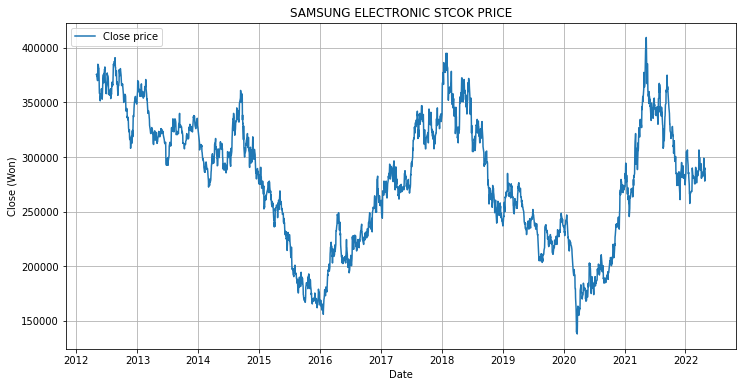

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_clo.index, df_clo.values, label='Close price')

plt.title(f'{company_name} STCOK PRICE')
plt.ylabel('Close (Won)')
plt.xlabel('Date')
plt.grid()
plt.legend()

plt.show()

# Preprocessing

## 거래량 0 제외

In [ ]:
# Volume값 0을 NaN으로 모두 대체(replace)
df['Volume'] = df['Volume'].replace(0,np.nan)

df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       17
dtype: int64

In [ ]:
# 모든 Missing Value 삭제
df = df.dropna()

## 정규화

In [ ]:
scaler = MinMaxScaler()
scale_cols = ['Close', 'Volume']     # ['Open','High', 'Low', 'Close', 'Adj Close', 'Volume']

scaled_df = scaler.fit_transform(df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
scaled_df

,Close,Volume
0,0.874770,0.025624
1,0.876611,0.038473
2,0.869245,0.015723
3,0.869245,0.029438
4,0.854512,0.048310
...,...,...
2438,0.545120,0.061566
2439,0.537753,0.076585
2440,0.515654,0.077316
2441,0.559853,0.088057


## 데이터 정의

In [ ]:
feature_list = {0: 'Close', 1: 'Volume'}   # 사용할 feature 리스트

In [ ]:
# param = 0       # Close만 선택
param = 0     # Close, Volume 둘 다 선택.

In [ ]:
if (param == 0):
    feature_cols= [feature_list[0]]
elif (param == 1):
    feature_cols= [feature_list[0], feature_list[1]]   

label_cols=[feature_list[0]]    

In [ ]:
label_df = pd.DataFrame(scaled_df, columns=label_cols)
feature_df = pd.DataFrame(scaled_df, columns=feature_cols)

label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

In [ ]:
time = 1   #  하루 예측
# time = 1   #  일주일 예측

In [ ]:
# 입력 파라미터 feature, label=> numpy type

def make_sequence_dataset(feature, label, window_size, time):

  feature_list=[] # 생성될 feature list
  label_list=[]   # 생성될 label list

  if (time == 0):
    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])      
  elif (time == 1):
    num = len(feature) % 5 

    for i in range(num, len(feature)-(window_size + 4), 5):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size:i+window_size+5])  

  return np.array(feature_list), np.array(label_list)

In [ ]:
if (time == 0):
    window_size = 50   # 50일동안의 데이터를 학습하고 51일째 주가를 예측.
    time_length = 'Daily'
elif (time == 1):
    window_size = 100   # 100일동안의 데이터로 다음주 동안의 주가를 예측    
    time_length = 'Weekly'

In [ ]:
X, y = make_sequence_dataset(feature_np, label_np, window_size, time)

print(X.shape, y.shape)

(468, 100, 1) (468, 5, 1)


In [ ]:
split = -int(X.shape[0] * 0.1)   # 90%를 훈련으로 사용

X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(422, 100, 1) (422, 5, 1)
(46, 100, 1) (46, 5, 1)


In [ ]:

def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu'))) 
    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop']),metrics = ['mse']) 
    return model

In [ ]:
es = EarlyStopping(
	monitor="val_loss",
	patience=5,
	restore_best_weights=True)

In [ ]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1,
        overwrite=True
        )

In [ ]:
tuner.search(
        x=X_train,
        y=y_train,
        epochs=20,                              
        batch_size=128,
        validation_data=(X_test,y_test),
        callbacks=[es]
)

Trial 2 Complete [00h 05m 28s]
mse: 0.06532841175794601

Best mse So Far: 0.0040236664935946465
Total elapsed time: 00h 10m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 384
n_layers: 4
lstm_0_units: 192
layer_2_neurons: 384
Dropout_rate: 0.0
dense_activation: tanh
optimizer: adam
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 32
Score: 0.0040236664935946465
Trial summary
Hyperparameters:
input_unit: 288
n_layers: 4
lstm_0_units: 384
layer_2_neurons: 96
Dropout_rate: 0.0
dense_activation: relu
optimizer: rmsprop
lstm_1_units: 288
lstm_2_units: 192
lstm_3_units: 448
Score: 0.06532841175794601


In [ ]:
if (time == 0):
    t = 1 # 하루
elif (time == 1):
    t = 5 # 일주일

if (param == 0):
    f = 'c' # 종가
elif (param == 1):
    f = 'cv' # 종가 + 거래량    


file_name = f'{stock_code}.{t}.{f}'

In [ ]:
best_model.save(f'/content/drive/MyDrive/models/{file_name}.h5') # 모델 저장

In [ ]:
new_model = tf.keras.models.load_model(f'/content/drive/MyDrive/models/{file_name}.h5', compile=False) # 모델 불러오기

In [ ]:
df.index[split:]

DatetimeIndex(['2022-02-10', '2022-02-11', '2022-02-14', '2022-02-15',
               '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-24',
               '2022-02-25', '2022-03-02', '2022-03-03', '2022-03-07',
               '2022-03-08', '2022-03-11', '2022-03-14', '2022-03-16',
               '2022-03-18', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01', '2022-04-04', '2022-04-05',
               '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-11',
               '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15',
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
df.index[-len(df.index[split:])*5:]

DatetimeIndex(['2021-05-07', '2021-05-10', '2021-05-11', '2021-05-12',
               '2021-05-13', '2021-05-14', '2021-05-17', '2021-05-18',
               '2021-05-20', '2021-05-21',
               ...
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29'],
              dtype='datetime64[ns]', name='Date', length=230, freq=None)

In [ ]:
time_arr = np.array(df.index[-len(df.index[split:])*5:]).reshape((-1, 5))
time_arr

array([['2021-05-07T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
        '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
        '2021-05-13T00:00:00.000000000'],
       ['2021-05-14T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
        '2021-05-18T00:00:00.000000000', '2021-05-20T00:00:00.000000000',
        '2021-05-21T00:00:00.000000000'],
       ['2021-05-24T00:00:00.000000000', '2021-05-25T00:00:00.000000000',
        '2021-05-26T00:00:00.000000000', '2021-05-27T00:00:00.000000000',
        '2021-05-28T00:00:00.000000000'],
       ['2021-05-31T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
        '2021-06-02T00:00:00.000000000', '2021-06-03T00:00:00.000000000',
        '2021-06-04T00:00:00.000000000'],
       ['2021-06-07T00:00:00.000000000', '2021-06-08T00:00:00.000000000',
        '2021-06-09T00:00:00.000000000', '2021-06-10T00:00:00.000000000',
        '2021-06-11T00:00:00.000000000'],
       ['2021-06-14T00:00:00.000000000', '2021-06-

In [ ]:
pred = new_model.predict(X_test)
print(pred)

[[0.7817339  0.78155637 0.78184575 0.78006357 0.7731105 ]
 [0.81222093 0.811692   0.8119177  0.8097862  0.80317044]
 [0.840104   0.83915174 0.83914554 0.8367074  0.83097357]
 [0.8552684  0.854344   0.8535228  0.85050166 0.8468765 ]
 [0.84531575 0.8457905  0.8433084  0.8392026  0.8383762 ]
 [0.8101021  0.8140935  0.80937195 0.8043825  0.80501294]
 [0.7690803  0.7772349  0.770992   0.7665186  0.7655185 ]
 [0.7467073  0.7561543  0.75010556 0.7473446  0.7431622 ]
 [0.74715346 0.75467515 0.7499257  0.7485389  0.742315  ]
 [0.7603669  0.76517415 0.76182735 0.7607829  0.7540819 ]
 [0.77189916 0.774922   0.7721428  0.77075815 0.765062  ]
 [0.7718551  0.77467304 0.7716337  0.7696457  0.7652753 ]
 [0.7638358  0.7675881  0.7642023  0.7618029  0.75766414]
 [0.7660492  0.7702799  0.76756907 0.7652739  0.7594007 ]
 [0.7830716  0.7860772  0.7841089  0.7821998  0.7758816 ]
 [0.78817916 0.79027826 0.7876265  0.7854955  0.78151417]
 [0.7639099  0.7675281  0.7629225  0.7601072  0.75886554]
 [0.7187435  0

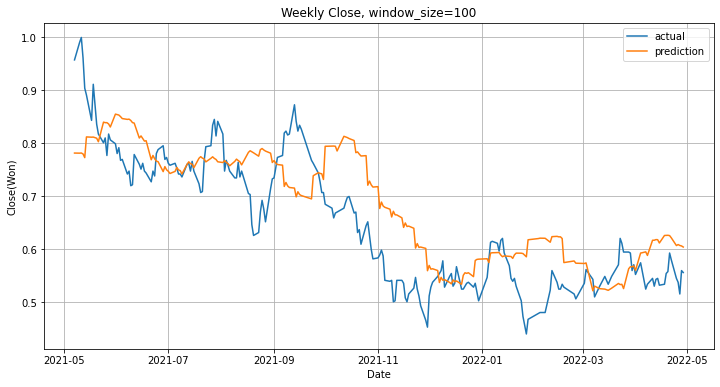

In [ ]:
plt.figure(figsize=(12, 6))

plt.title(f'{time_length} Close, window_size={window_size}')
plt.ylabel('Close(Won)')
plt.xlabel('Date')

if (time == 0): 
    plt.plot(df.index[split:], y_test, label='actual')
    plt.plot(df.index[split:], pred, label='prediction')
elif (time == 1):    
    plt.plot(time_arr.flatten(), y_test.flatten(), label='actual')
    plt.plot(time_arr.flatten(), pred.flatten(), label='prediction')

plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
X_for_predict = scaled_df[feature_cols].values[-window_size:].reshape(1, window_size, len(feature_cols))

In [ ]:
result = new_model.predict(X_for_predict)
result # 미래 예측값

array([[0.580785  , 0.5858372 , 0.58316964, 0.58227247, 0.5790567 ]],
      dtype=float32)

In [ ]:
scale_back = scaler.inverse_transform(scaled_df) # 원래 값으로
scale_back

array([[375500., 130640.],
       [376000., 173976.],
       [374000.,  97247.],
       ...,
       [278000., 304986.],
       [290000., 341213.],
       [289000., 178473.]])

In [ ]:
scale_back_df = pd.DataFrame(scale_back)    # 기존 데이터 원래 값으로
scale_back_df

,0,1
0,375500.0,130640.0
1,376000.0,173976.0
2,374000.0,97247.0
3,374000.0,143503.0
4,370000.0,207154.0
...,...,...
2438,286000.0,251867.0
2439,284000.0,302521.0
2440,278000.0,304986.0
2441,290000.0,341213.0


In [ ]:
scale_back_df.describe()

,0,1
count,2443.000000,2.443000e+03
mean,279061.809251,2.893778e+05
std,58273.929037,1.899060e+05
min,138000.000000,4.421500e+04
25%,233750.000000,1.754780e+05
50%,282500.000000,2.442100e+05
75%,325250.000000,3.479785e+05
max,409500.000000,3.417026e+06


In [ ]:
close_min = min(scale_back_df[0])
close_min

138000.0

In [ ]:
close_max = max(scale_back_df[0])
close_max

409500.0

In [ ]:
def back_values(list):
    new_list = list * (close_max - close_min) + close_min
    return new_list

In [ ]:
back_values(pred.flatten())  # 테스트셋, 원래 값으로

array([350240.75, 350192.56, 350271.12, 349787.25, 347899.5 , 358518.  ,
       358374.38, 358435.66, 357856.94, 356060.78, 366088.25, 365829.7 ,
       365828.  , 365166.06, 363609.3 , 370205.38, 369954.4 , 369731.44,
       368911.2 , 367926.97, 367503.25, 367632.12, 366958.25, 365843.5 ,
       365619.12, 357942.72, 359026.38, 357744.5 , 356389.84, 356561.  ,
       346805.3 , 349019.28, 347324.3 , 346109.8 , 345838.25, 340731.03,
       343295.88, 341653.66, 340904.06, 339768.56, 340852.2 , 342894.3 ,
       341604.8 , 341228.3 , 339538.5 , 344439.62, 345744.78, 344836.12,
       344552.56, 342733.25, 347570.62, 348391.3 , 347636.78, 347260.84,
       345714.3 , 347558.66, 348323.75, 347498.56, 346958.8 , 345772.25,
       345381.44, 346400.16, 345480.94, 344829.5 , 343705.8 , 345982.38,
       347131.  , 346395.  , 345771.88, 344177.3 , 350603.94, 351419.94,
       350885.56, 350367.25, 348651.84, 351990.62, 352560.56, 351840.6 ,
       351262.03, 350181.1 , 345401.53, 346383.88, 

In [ ]:
back_values(result.flatten())  # 미래예측값, 원래 값으로

array([295683.12, 297054.8 , 296330.56, 296086.97, 295213.88],
      dtype=float32)